In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import os
from datetime import datetime
import time
import plotly
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import librosa

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
import plotly.figure_factory as ff
from sklearn.preprocessing import OneHotEncoder
from data_set_params import DataSetParams
from scipy.io import wavfile
params = DataSetParams()

In [3]:
#os.listdir('ff1010bird/ff1010bird_wav/wav')
#os.listdir('warblrb10k_public/warblrb10k_public_wav/wav')

In [4]:
data_dir   = 'warblrb10k_public/warblrb10k_public_wav/wav'#'richfield_birds_split'
categories = np.array(tf.io.gfile.listdir(data_dir))
categories = [category for category in categories if 'wav' not in category and '.TAG' not in category]
categories

['bird', 'not_bird']

In [5]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple unpacking to enable this 
    # to work in a TensorFlow graph.
    return parts[-2]

In [6]:
def preload_vgg19(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        Flatten(), # Flatten dimensions to for use in FC layers
        Dense(256, activation='relu'),
        Dropout(0.5), # Dropout layer to reduce overfitting
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax') # Softmax for multiclass
    ])
    model.compile(
        optimizer = optimizers.Adam(learning_rate=0.0001),
        loss      = losses.SparseCategoricalCrossentropy(),
        metrics   = 'accuracy'
        )
    return model

In [7]:
def preload_vgg19_concat(input_shape, num_channels):
    from tensorflow.keras.layers import concatenate
    out_list   = []
    input_list = []
    for c in range(num_channels):
        input_a = layers.Input(shape=input_shape)
        input_list.append(input_a)
        #out_list.append(vgg_model.output)
    #vgg_model.summary()
    #x = vgg_model.output
    concatenated = concatenate(input_list, axis=-1)
    x = Flatten()(concatenated) # Flatten dimensions to for use in FC layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
    x = Dense(64, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x) # Softmax for multiclass
    concat_vgg_model = Model(inputs=input_list, outputs=x)
    concat_vgg_model.compile(
        optimizer = optimizers.Adam(learning_rate=0.0001),
        loss      = losses.SparseCategoricalCrossentropy(),
        metrics   = 'accuracy'
        )
    return concat_vgg_model

In [8]:
def preload_vgg19_mfcc(input_shape, mfcc_shape):
    from tensorflow.keras.layers import concatenate
    input_list = [layers.Input(shape=input_shape), layers.Input(shape=mfcc_shape)]
    x = Flatten()(input_list[0]) # Flatten dimensions to for use in FC layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
    x = Dense(64, activation='relu')(x)
    concatenated = concatenate([x, input_list[1]], axis=-1)
    x = Dense(num_classes, activation='softmax')(concatenated) # Softmax for multiclass
    vgg_mfcc_model = Model(inputs=input_list, outputs=x)
    vgg_mfcc_model.compile(
        optimizer = optimizers.Adam(learning_rate=0.0001),
        loss      = losses.SparseCategoricalCrossentropy(),
        metrics   = 'accuracy'
        )
    return vgg_mfcc_model

In [9]:
def preload_vgg19_mfcc_umap(input_shape, umap_shape):
    from tensorflow.keras.layers import concatenate
    input_list = [layers.Input(shape=input_shape), layers.Input(shape=umap_shape)]
    x = Flatten()(input_list[0]) # Flatten dimensions to for use in FC layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
    x = Dense(64, activation='relu')(x)
    concatenated = concatenate([x, input_list[1]], axis=-1)
    x = Dense(num_classes, activation='softmax')(concatenated) # Softmax for multiclass
    vgg_mfcc_umap_model = Model(inputs=input_list, outputs=x)
    vgg_mfcc_umap_model.compile(
        optimizer = optimizers.Adam(learning_rate=0.0001),
        loss      = losses.SparseCategoricalCrossentropy(),
        metrics   = 'accuracy'
        )
    return vgg_mfcc_umap_model

In [10]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
#filenames = tf.io.gfile.glob('birds/*/*')
filenames = [filename for filename in filenames if 'wav' in filename]
#filenames = tf.random.shuffle(filenames)

In [11]:
AUTOTUNE   = tf.data.experimental.AUTOTUNE
batch_size = 32
EPOCHS     = 50

In [12]:
num_classes = len(categories)

In [13]:
from tf_helpers import *

In [14]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, top_k_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from math import prod

In [15]:
def save_results(model, x_test, y_true, name, filename_run, index):
        #model.save('models/'+filename_run+'.h5')
    
        pred_lists = model.predict(x_test)
        y_pred     = np.argmax(pred_lists, axis=-1)
        pred_df    = pd.DataFrame(pred_lists, columns = categories)
        
        softmax_prediction_df = pred_df.apply(lambda x: np.exp(x - np.max(x))/np.exp(x - np.max(x)).sum(), axis=1)
        softmax_prediction_df.to_csv('results/'+filename_run+'_softmax_prediction_df.csv')
        
        cm = confusion_matrix(y_true, y_pred)
        fig = plotly_cm(cm, categories)
        fig.write_html('results/'+filename_run+'_confusion_matrix.html')
        
        num_trainable    = sum([prod(w.shape) for w in model.trainable_weights])
        num_nontrainable = sum([prod(w.shape) for w in model.non_trainable_weights])
        
        onehot_data = OneHotEncoder(sparse=False)
        onehot_data = onehot_data.fit_transform(np.array(y_true).reshape(len(y_true),1))
        roc_auc = [0]*num_classes
        
        for i in range(num_classes):
            roc_auc[i] = roc_auc_score(onehot_data[:, i], softmax_prediction_df.to_numpy()[:, i])
        
        name_df = pd.DataFrame(data={
                  'model':     name}, index=[index])
        metric_df = pd.DataFrame(data={
                  'top_1_acc': [accuracy_score(y_pred, y_true)],
                  #'top_5_acc': [top_k_accuracy_score(y_true, softmax_prediction_df, k=5)],
                  'precision': [precision_score(y_pred, y_true, average = 'weighted')], 
                  'f1':        [f1_score(y_pred, y_true, average = 'weighted')]
                 })
        param_df = pd.DataFrame(data={
                  'trainable_params': [num_trainable],
                  'nontrainable_params': [num_nontrainable]
                 })
        auc_df = pd.DataFrame([roc_auc], columns = ['auc_'+categories[i].replace(' ', '') for i in range(num_classes)])
        
        metric_df =  pd.concat([name_df, metric_df],axis=1)
        metric_df.to_csv('results/'+filename_run+'_metric_df.csv')
        
        param_df  =  pd.concat([name_df, param_df],axis=1)
        param_df.to_csv('results/'+filename_run+'_param_df.csv')
        
        auc_df    =  pd.concat([name_df, auc_df],axis=1)
        auc_df.to_csv('results/'+filename_run+'_auc_df.csv')

In [16]:
def load_vgg19(input_shape):
    vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    vgg_model.trainable = False ## Not trainable weights
    #vgg_model.summary()
    x = vgg_model.output
    x = Flatten()(x) # Flatten dimensions to for use in FC layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
    x = Dense(64, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x) # Softmax for multiclass
    transfer_vgg_model = Model(inputs=vgg_model.input, outputs=x)
    transfer_vgg_model.compile(
        optimizer = optimizers.Adam(learning_rate=0.0001),
        loss      = losses.SparseCategoricalCrossentropy(),
        metrics   = 'accuracy'
        )
    return transfer_vgg_model

In [17]:
def load_vgg19_concat(input_shape, num_channels):
    from tensorflow.keras.layers import concatenate
    out_list   = []
    input_list = []
    for c in range(num_channels):
        vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        vgg_model._name = vgg_model._name + str(c)
        for layer in vgg_model.layers:
            layer._name = layer._name + '_' + str(c)
        vgg_model.trainable = False ## Not trainable weights
        input_a = vgg_model.input
        input_list.append(input_a)
        out_list.append(vgg_model.output)
    #vgg_model.summary()
    #x = vgg_model.output
    concatenated = concatenate(out_list)
    x = Flatten()(concatenated) # Flatten dimensions to for use in FC layers
    x = Dense(256*num_channels, activation='relu')(x)
    x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
    x = Dense(64*num_channels, activation='relu')(x)
    x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
    x = Dense(64, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x) # Softmax for multiclass
    concat_vgg_model = Model(inputs=input_list, outputs=x)
    concat_vgg_model.compile(
        optimizer = optimizers.Adam(learning_rate=0.0001),
        loss      = losses.SparseCategoricalCrossentropy(),
        metrics   = 'accuracy'
        )
    return concat_vgg_model

In [18]:
def load_resnet50(input_shape):
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    resnet_model.trainable = False ## Not trainable weights
    #resnet_model.summary()
    x = resnet_model.output
    x = Flatten()(x) # Flatten dimensions to for use in FC layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
    x = Dense(64, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x) # Softmax for multiclass
    transfer_resnet_model = Model(inputs=resnet_model.input, outputs=x)
    transfer_resnet_model.compile(
        optimizer = optimizers.Adam(learning_rate=0.0001),
        loss      = losses.SparseCategoricalCrossentropy(),
        metrics   = 'accuracy'
        )
    return transfer_resnet_model

In [19]:
def load_resnet50_concat(input_shape, num_channels):
    from tensorflow.keras.layers import concatenate
    out_list   = []
    input_list = []
    for c in range(num_channels):
        resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        resnet_model._name = resnet_model._name + str(c)
        for layer in resnet_model.layers:
            layer._name = layer._name + '_' + str(c)
        resnet_model.trainable = False ## Not trainable weights
        input_a = resnet_model.input
        input_list.append(input_a)
        out_list.append(resnet_model.output)
    #vgg_model.summary()
    #x = vgg_model.output
    concatenated = concatenate(out_list)
    x = Flatten()(concatenated) # Flatten dimensions to for use in FC layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
    x = Dense(64, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x) # Softmax for multiclass
    concat_resnet_model = Model(inputs=input_list, outputs=x)
    concat_resnet_model.compile(
        optimizer = optimizers.Adam(learning_rate=0.0001),
        loss      = losses.SparseCategoricalCrossentropy(),
        metrics   = 'accuracy'
        )
    return concat_resnet_model

In [20]:
def main_model_run(filenames, index,
                   vgg19        = False,
                   vgg19_concat = False,
                   resnet50     = False,
                   resnet50_concat = False,
                   smallcnn = False,
                   concat   = False,
                   concat2  = False,
                   concat3  = False,
                   concat4  = False,
                   vgg_mfcc = False,
                   vgg_umap = False,
                   vgg_pca  = False,
                   smallcnn_mfcc = False):
    print("Index: ", index)
    
    filenames   = tf.random.shuffle(filenames)
    all_labs    = [get_label(y).numpy().decode() for y in filenames]
    filename_df = pd.DataFrame({'name': filenames.numpy(),
                                'label': all_labs})
    
    train, rest_df = train_test_split(filename_df, test_size=0.2, stratify=filename_df[['label']])
    val, test      = train_test_split(rest_df, test_size=0.5, stratify = rest_df[['label']])
    
    train_files = tf.random.shuffle(train['name'])
    val_files   = tf.random.shuffle(val['name'])
    test_files  = tf.random.shuffle(test['name'])

    def concat_xy(ds):
            x_tmp  = [x for x,_ in ds]
            x_tmp  = tf.stack(x_tmp)
            xs_tmp = tf.unstack(x_tmp, axis=-1)
            xs_tmp = [tf.expand_dims(x_ind, axis=-1) for x_ind in xs_tmp]
            y      = np.array([y for _,y in ds])
            return xs_tmp, y
    
    print('Getting data')
    choices  = ['Mod']
    train_ds = preprocess_dataset(train_files, choices, categories, req_width=750, resize = 4, spec_norm = True)
    val_ds   = preprocess_dataset(val_files,   choices, categories, req_width=750, resize = 4, spec_norm = True)
    test_ds  = preprocess_dataset(test_files,  choices, categories, req_width=750, resize = 4, spec_norm = True)
    
    train_ds_vgg = preprocess_dataset(train_files, choices, categories, req_width=750, single_to_rgb = True, resize = 4, spec_norm = True)
    val_ds_vgg   = preprocess_dataset(val_files,   choices, categories, req_width=750, single_to_rgb = True, resize = 4, spec_norm = True)
    test_ds_vgg  = preprocess_dataset(test_files,  choices, categories, req_width=750, single_to_rgb = True, resize = 4, spec_norm = True)
    
    X_train_vgg = np.array([x for x,y in train_ds_vgg])
    X_val_vgg   = np.array([x for x,y in val_ds_vgg])
    X_test_vgg  = np.array([x for x,y in test_ds_vgg])
    
    y_train = np.array([y for _,y in train_ds_vgg])
    y_val   = np.array([y for _,y in val_ds_vgg])
    y_test  = np.array([y for _,y in test_ds_vgg])
    
    if vgg_mfcc or smallcnn_mfcc or vgg_umap or vgg_pca:
        print("MFCC features")
        def get_features(waveform, sr):
            #audio = np.array(audio)#.numpy()
            waveform = waveform[:sr]  # analyze just first second
            S = librosa.feature.melspectrogram(waveform, sr=sr, n_mels=128)
            log_S = librosa.amplitude_to_db(S, ref=np.max)
            mfcc  = librosa.feature.mfcc(S=log_S, n_mfcc=13)
            delta_mfcc  = librosa.feature.delta(mfcc, mode='nearest')
            delta2_mfcc = librosa.feature.delta(mfcc, order=2, mode='nearest')
            feature_vector = np.concatenate((np.mean(mfcc,1), np.mean(delta_mfcc,1), np.mean(delta2_mfcc,1)))
            feature_vector = (feature_vector-np.mean(feature_vector)) / (np.std(feature_vector)+np.finfo(np.float32).eps)
            return feature_vector
        
        def get_pca(features):
            pca = PCA(n_components=5)
            transformed = pca.fit(features).transform(features)
            scaler = MinMaxScaler()
            scaler.fit(transformed)
            return scaler.transform(transformed)

        def get_mfcc_features(file_names):
            feature_vectors = []
            sound_paths     = []
            for i,f in enumerate(file_names):
                #f = f.numpy()
                if i % 100 == 0:
                    print("get %d of %d = %s"%(i+1, len(file_names), f))
                try:
                    #print(f)
                    #print(type(f))
                    y, sr = librosa.load(f)
                    #print(len(y))
                    #print(len(y)<2)
                    if len(y) < 2:
                        print("error loading %s" % f)
                        continue
                    feat = get_features(y, sr)
                    #print(feat)
                    feature_vectors.append(feat)
                    sound_paths.append(f)
                except:
                    print("error loading %s" % f)

            print("calculated %d feature vectors"%len(feature_vectors))
            return np.array(feature_vectors)
        
        train_files = [f.decode().replace('\\', '/') for f in train['name'].to_list()]
        val_files   = [f.decode().replace('\\', '/') for f in val['name'].to_list()]
        test_files  = [f.decode().replace('\\', '/') for f in test['name'].to_list()]
        
        train_mfcc = get_mfcc_features(train_files)
        val_mfcc   = get_mfcc_features(val_files)
        test_mfcc  = get_mfcc_features(test_files)
        
        #exclude_idx = np.unique(np.where(np.isnan(test_mfcc))[0])
        #feature_sub = [feature_vectors[i] for i in range(len(feature_vectors)) if i not in exclude_idx]
        #class_sub   = [class_smp[i] for i in range(len(class_smp)) if i not in exclude_idx]
        
        #tsne_embed = TSNE(n_components=2, learning_rate=150, perplexity=30, verbose=2, angle=0.1).fit(train_mfcc)
        
        umap_embed = umap.UMAP(n_neighbors=5, random_state=42, n_components=10).fit(train_mfcc)
        
        umap_embed_train = umap_embed.embedding_
        umap_embed_val   = umap_embed.transform(val_mfcc)
        umap_embed_test  = umap_embed.transform(test_mfcc)
        #test_embedding = trans.transform(X_test)
        #pca_embed  = get_pca(feature_sub)
        pca_embed = PCA(n_components=5).fit(train_mfcc)
        
        pca_embed_train = pca_embed.embedding_
        
        scaler = MinMaxScaler()
        scaler.fit(pca_embed_train)
        
        pca_embed_train = scaler.transform(pca_embed_train)
        
        pca_embed_val   = scaler.transform(pca_embed.transform(val_mfcc))
        pca_embed_test  = scaler.transform(pca_embed.transform(test_mfcc))
        #transformed = pca.fit(features).transform(features)
        #scaler = MinMaxScaler()
        #scaler.fit(transformed)
        #return scaler.transform(transformed)

    print("Done")
    
    
    #concat_shape     = X_train_mult[0].shape[1:]
    #vgg_concat_shape = X_train_mult_vgg[0].shape[1:]
    
    for spec, _ in train_ds.take(1):
        input_shape = spec.shape
    for spec, _ in train_ds_vgg.take(1):
        input_shape_vgg = spec.shape
        #print(tf.math.reduce_std(spec[:,:,0]))
        #print(tf.math.reduce_std(spec[:,:,1]))
        #print(tf.math.reduce_std(spec[:,:,2]))
        
    train_ds = train_ds.batch(batch_size)
    val_ds   = val_ds.batch(batch_size)
    test_ds  = test_ds.batch(batch_size)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds   = val_ds.cache().prefetch(AUTOTUNE)
    test_ds  = test_ds.cache().prefetch(AUTOTUNE)
    
    if data_dir.startswith("C:"):
        sv_dir = '_'.join(data_dir.split(os.path.sep)[1:-2])
    else:
        sv_dir = data_dir
    filename_idx = datetime.now().strftime("%Y%m%d-%H%M%S").replace('-', '_')+'_'+sv_dir.replace('/','_')+'_'+str(index)
    results_folder = 'results'
    if not os.path.isdir(results_folder):
        os.mkdir(results_folder)
    
    train.to_csv(results_folder+'/'+filename_idx+'_filenames_train.csv')
    val.to_csv(results_folder+'/'+filename_idx+'_filenames_val.csv')
    test.to_csv(results_folder+'/'+filename_idx+'_filenames_test.csv')
    #np.save('results/'+filename_idx+'_filenames.npy', filenames.numpy())
    
    #this will save the model performing best on val accuracy
    def best_model_cp():
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            "best_model",
            monitor = "val_accuracy",
            mode    = "max",
            save_best_only = True,
            save_weights_only = True)
        return checkpoint
    
    ## Load and run models
    
    if vgg19 or vgg19_concat:
        vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape_vgg)
    #VGG19
    if vgg19:
        print("VGG19")
        tmp_vgg_trainX = vgg_model.predict(X_train_vgg)
        tmp_vgg_valX   = vgg_model.predict(X_val_vgg)
        tmp_vgg_testX  = vgg_model.predict(X_test_vgg)
        model = preload_vgg19(tmp_vgg_trainX.shape[1:])
        model_name   = 'vgg19'
        filename_run = filename_idx+'_'+model_name
        print(model.summary())
        history = model.fit(tmp_vgg_trainX, y_train,
                            validation_data = (tmp_vgg_valX, y_val),
                            callbacks       = [best_model_cp()],
                            epochs          = EPOCHS,
                            verbose         = 1)

        pd.DataFrame(history.history).to_csv(results_folder+'/'+filename_run+'_model_history.csv')

        model.load_weights("best_model")

        save_results(model, tmp_vgg_testX, y_test, model_name, filename_run, index)
    
    
    #VGG19_concat
    if vgg19_concat:
        print("VGG19_concat")
        tmp_X_train_mult_vgg = [vgg_model.predict(xt) for xt in X_train_mult_vgg]
        tmp_X_val_mult_vgg   = [vgg_model.predict(xt) for xt in X_val_mult_vgg]
        tmp_X_test_mult_vgg  = [vgg_model.predict(xt) for xt in X_test_mult_vgg]
        #model    = load_vgg19_concat(vgg_concat_shape, num_channels)
        model_name   = 'vgg19_concat'
        filename_run = filename_idx+'_'+model_name
        model = preload_vgg19_concat(tmp_X_train_mult_vgg[0].shape[1:], num_channels)
        print(model.summary())
        history = model.fit(tmp_X_train_mult_vgg, y_train,
                            validation_data = (tmp_X_val_mult_vgg, y_val),
                            callbacks       = [best_model_cp()],
                            epochs          = EPOCHS,
                            verbose         = 1)

        pd.DataFrame(history.history).to_csv(results_folder+'/'+filename_run+'_model_history.csv')

        model.load_weights("best_model")

        save_results(model, tmp_X_test_mult_vgg, y_test, model_name, filename_run, index)


    #ResNet50
    if resnet50:
        print("ResNet50")
        model = load_resnet50(input_shape_vgg)
        model_name   = 'resnet50'
        filename_run = filename_idx+'_'+model_name

        history = model.fit(train_ds,
                            validation_data = val_ds,
                            callbacks       = [best_model_cp()],
                            epochs          = EPOCHS,
                            verbose         = 1)

        pd.DataFrame(history.history).to_csv(results_folder+'/'+filename_run+'_model_history.csv')

        model.load_weights("best_model")

        save_results(model, test_ds, y_test, model_name, filename_run, index)
    
    #ResNet50_concat
    if resnet50_concat:
        print("ResNet50_concat")
        model    = load_resnet50_concat(vgg_concat_shape, num_channels)
        model_name   = 'resnet50_concat'
        filename_run = filename_idx+'_'+model_name

        history = model.fit(X_train_vgg, y_train,
                            validation_data = (X_val_vgg, y_val),
                            callbacks       = [best_model_cp()],
                            epochs          = EPOCHS,
                            verbose         = 1)

        pd.DataFrame(history.history).to_csv(results_folder+'/'+filename_run+'_model_history.csv')

        model.load_weights("best_model")

        save_results(model, X_test_vgg, y_test, model_name, filename_run, index)

    #small_cnn
    if smallcnn:
        print("Small CNN")
        model  = main_cnn(input_shape, num_classes)
        model_name   = 'smallcnn'
        filename_run = filename_idx+'_'+model_name

        history = model.fit(train_ds,
                            validation_data = val_ds,
                            callbacks       = [best_model_cp()],
                            epochs          = EPOCHS,
                            verbose         = 1)

        pd.DataFrame(history.history).to_csv(results_folder+'/'+filename_run+'_model_history.csv')

        model.load_weights("best_model")

        save_results(model, test_ds, y_test, model_name, filename_run, index)
    
    #concat
    if concat:
        print("Concat")
        model        = concat_model(concat_shape, num_channels, num_classes)
        model_name   = 'concat'
        filename_run = filename_idx+'_'+model_name

        history = model.fit(X_train_mult, y_train,
                            validation_data = (X_val_mult, y_val),
                            callbacks       = [best_model_cp()],
                            epochs          = EPOCHS,
                            batch_size      = batch_size,
                            verbose         = 1)

        pd.DataFrame(history.history).to_csv(results_folder+'/'+filename_run+'_model_history.csv')

        model.load_weights("best_model")

        save_results(model, X_test_mult, y_test, model_name, filename_run, index)

    #concat2
    if concat2:
        print("Concat2")
        model     = concat_model2(concat_shape, num_channels, num_classes)
        model_name   = 'concat2'
        filename_run = filename_idx+'_'+model_name

        history = model.fit(X_train_mult, y_train,
                            validation_data = (X_val_mult, y_val),
                            callbacks       = [best_model_cp()],
                            epochs          = EPOCHS,
                            batch_size      = batch_size,
                            verbose         = 1)

        pd.DataFrame(history.history).to_csv(results_folder+'/'+filename_run+'_model_history.csv')

        model.load_weights("best_model")

        save_results(model, X_test_mult, y_test, model_name, filename_run, index)
    
    #concat3
    if concat3:
        print("Concat3")
        model     = concat_model3(concat_shape, num_channels, num_classes)
        model_name   = 'concat3'
        filename_run = filename_idx+'_'+model_name

        history = model.fit(X_train_mult, y_train,
                            validation_data = (X_val_mult, y_val),
                            callbacks       = [best_model_cp()],
                            epochs          = EPOCHS,
                            batch_size      = batch_size,
                            verbose         = 1)

        pd.DataFrame(history.history).to_csv(results_folder+'/'+filename_run+'_model_history.csv')

        model.load_weights("best_model")

        save_results(model, X_test_mult, y_test, model_name, filename_run, index)
    
    #concat4
    if concat4:
        print("Concat4")
        model     = concat_model4(concat_shape, num_channels, num_classes)
        model_name   = 'concat4'
        filename_run = filename_idx+'_'+model_name

        history = model.fit(X_train_mult, y_train,
                            validation_data = (X_val_mult, y_val),
                            callbacks       = [best_model_cp()],
                            epochs          = EPOCHS,
                            batch_size      = batch_size,
                            verbose         = 1)

        pd.DataFrame(history.history).to_csv(results_folder+'/'+filename_run+'_model_history.csv')

        model.load_weights("best_model")

        save_results(model, X_test_mult, y_test, model_name, filename_run, index)

    if vgg_mfcc:
        print("VGG MFCC")
        
        model        = preload_vgg19_mfcc(tmp_vgg_trainX.shape[1:], train_mfcc.shape[-1])
        #model        = concat_model4(concat_shape, num_channels, num_classes)
        model_name   = 'vgg_mfcc'
        filename_run = filename_idx+'_'+model_name

        history = model.fit([tmp_vgg_trainX, train_mfcc], y_train,
                            validation_data = ([tmp_vgg_valX, val_mfcc], y_val),
                            callbacks       = [best_model_cp()],
                            epochs          = EPOCHS,
                            batch_size      = batch_size,
                            verbose         = 1)

        pd.DataFrame(history.history).to_csv(results_folder+'/'+filename_run+'_model_history.csv')

        model.load_weights("best_model")

        save_results(model, [tmp_vgg_testX, test_mfcc], y_test, model_name, filename_run, index)
        
    if vgg_umap:
        print("VGG MFCC Umap")
        
        model        = preload_vgg19_mfcc_umap(tmp_vgg_trainX.shape[1:], umap_embed_train.shape[-1])
        #model        = concat_model4(concat_shape, num_channels, num_classes)
        model_name   = 'vgg_mfcc_umap'
        filename_run = filename_idx+'_'+model_name

        history = model.fit([tmp_vgg_trainX, umap_embed_train], y_train,
                            validation_data = ([tmp_vgg_valX, umap_embed_val], y_val),
                            callbacks       = [best_model_cp()],
                            epochs          = EPOCHS,
                            batch_size      = batch_size,
                            verbose         = 1)

        pd.DataFrame(history.history).to_csv(results_folder+'/'+filename_run+'_model_history.csv')

        model.load_weights("best_model")

        save_results(model, [tmp_vgg_testX, umap_embed_test], y_test, model_name, filename_run, index)
        
    if vgg_pca:
        print("VGG MFCC PCA")
        
        model        = preload_vgg19_mfcc_umap(tmp_vgg_trainX.shape[1:], pca_embed_train.shape[-1])
        #model        = concat_model4(concat_shape, num_channels, num_classes)
        model_name   = 'vgg_mfcc_pca'
        filename_run = filename_idx+'_'+model_name

        history = model.fit([tmp_vgg_trainX, pca_embed_train], y_train,
                            validation_data = ([tmp_vgg_valX, pca_embed_val], y_val),
                            callbacks       = [best_model_cp()],
                            epochs          = EPOCHS,
                            batch_size      = batch_size,
                            verbose         = 1)

        pd.DataFrame(history.history).to_csv(results_folder+'/'+filename_run+'_model_history.csv')

        model.load_weights("best_model")

        save_results(model, [tmp_vgg_testX, pca_embed_test], y_test, model_name, filename_run, index)
           
    #if smallcnn_mfcc:
        

## Evaluate

In [21]:
tic = time.time()

In [22]:
len(filenames)

8000

In [23]:
#for i in range(1,5+1):
#    main_model_run(filenames[:2000], i,
#                   vgg19        = True,
                   #vgg19_concat = True
                   #resnet50     = True,
                   #resnet50_concat = True,
                   #smallcnn     = True,
                   #concat   = True
                  #)
                   #concat2  = True,
                   #concat3  = True,
                   #concat4  = True,
#                    vgg_mfcc = True,
#                    vgg_umap = True,
#                    vgg_pca  = True)#,
                    #smallcnn_mfcc = True)
#    print("Time so far:", time.time() - tic)

In [33]:
#filenames   = tf.random.shuffle(filenames)
def concat_xy(ds):
        x_tmp  = [x for x,_ in ds]
        x_tmp  = tf.stack(x_tmp)
        xs_tmp = tf.unstack(x_tmp, axis=-1)
        xs_tmp = [tf.expand_dims(x_ind, axis=-1) for x_ind in xs_tmp]
        y      = np.array([y for _,y in ds])
        return xs_tmp, y

print('Getting data')
choices  = ['Mod']
#main_ds = preprocess_dataset(filenames, choices, categories, req_width=750, resize = 4, spec_norm = True)

main_ds_vgg = preprocess_dataset(filenames, choices, categories, req_width=125, single_to_rgb = True, resize = 4, spec_norm = True)
print("Get VGG input data")
X = np.array([x for x,_ in main_ds_vgg])
#y = np.array([y for _,y in main_ds_vgg])

#for spec, _ in train_ds.take(1):
#    input_shape = spec.shape
print("Get VGG precomputed data")
for spec, _ in main_ds_vgg.take(1):
    input_shape_vgg = spec.shape
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape_vgg)
tmp_vgg_X = vgg_model.predict(X)

Getting data
Get VGG input data
Get VGG precomputed data


In [25]:
toc = time.time()

In [26]:
#librosa.load('richfield_birds_split/Common Kestrel/xc672833_start_1_30.wav')

In [27]:
print(toc-tic)

10.938694715499878


In [28]:
fname = data_dir.split('/')[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


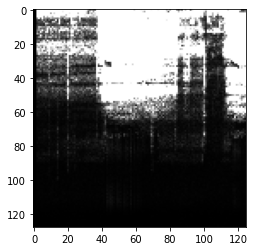

In [32]:
import matplotlib.pyplot as plt
plt.imshow(X[0,:,:125])

In [34]:
np.save(fname+'_vgg1.npy', tmp_vgg_X)

In [35]:
np.save(fname+'_spec1.npy', X)

In [37]:
fname

'warblrb10k_public'

In [36]:
np.save(fname+'_vgg_filenames1.npy', np.array(filenames))

In [27]:
#print(res_df_t.to_latex(bold_rows = True))

In [28]:
#!zip -r results.zip results